In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats


In [7]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [13]:
# for Amon data
def model_climate_timeseries(model, variable):

    # Extract the part of the catalog that goes with these search terms
    model_var_hist = catalog.search(source_id = model, experiment_id='historical', table_id= 'Amon', variable_id=variable)
    model_var_ssp = catalog.search(source_id = model, experiment_id='ssp370', table_id= 'Amon', variable_id=variable)
    
    # Make a list of the unique ensemble members
    # historical
    mems_hist = model_var_hist.df.member_id.unique()
    # SSP
    mems_ssp = model_var_ssp.df.member_id.unique()

    # Convert these to sets, find the intersection between them, and convert back to a list
    common_mems = list(set(mems_hist) & set(mems_ssp))
    
    # Define an empty list for output data
    model_data = []

    # Retrieve number of members the historical and SSP ensembles have in common
    num = len(common_mems)

    # Loop over all members-in-common
    for mem in range(num):
        # Print statement to keep track of which member we're working on
        print(common_mems[mem])
    
        # Figure out where this member is in the historical ensemble
        # True/False array showing whether or not the member_id matches our member of interest
        hist_mask = model_var_hist.df['member_id'] == common_mems[mem]
        # extract (first) location where the mask is True
        hist_loc = model_var_hist.df['member_id'][hist_mask].index[0]
    
        # Do the same thing for the SSP ensemble
        ssp_mask = model_var_ssp.df['member_id'] == common_mems[mem]
        ssp_loc = model_var_ssp.df['member_id'][ssp_mask].index[0]
    
        # Extract data from each entry as xarray
        data_hist = xr.open_zarr(model_var_hist.df['zstore'][hist_loc], storage_options={'anon': True})
        data_ssp = xr.open_zarr(model_var_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
        data_hist['time'] = data_hist.time.astype('datetime64[ns]')
        data_ssp['time'] = data_ssp.time.astype('datetime64[ns]')
    
        data_hist = data_hist.sel(time = slice('1850-01-01', '2014-12-31'))
        data_ssp = data_ssp.sel(time = slice('2015-01-01', '2100-12-31'))
    
        # Concatenate the historical and SSP data across the time dimension
        data = xr.concat([data_hist, data_ssp], dim="time")
        
        # Narrow down to Indonesia
        data = data.sel(lon=slice(92, 146), lat=slice(-15, 10))
    
        # Add the concatenated data to a list
        model_data.append(data)

    # Concatenate the list into a single xarray object
    model_data = xr.concat(model_data, dim="member")

    # Store the actual member information as values of the new dimension
    model_data = model_data.assign_coords(member=("member", common_mems))
    
     # Compute spatial mean over lat & lon for each member & time
    ts_by_member = model_data[variable].mean(dim=["lat", "lon"])
    
    # Compute ensemble mean and standard deviation across members
    ens_mean = ts_by_member.mean(dim="member")
    ens_std  = ts_by_member.std(dim="member")
    
     # Plot the ensemble mean time series
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.plot(ens_mean['time'].values,
        ens_mean.values,
        color='firebrick',
        linewidth=2,
        label='Ensemble mean')
    
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel(f"{variable} ({model_data[variable].units})", fontsize=16)
    ax.set_title(f"{model} – Ensemble‐mean average of '{variable}' in Indonesia", fontsize=18)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


r1i1p1f1
r3i1p1f1
r4i1p1f1
r2i1p1f1
r5i1p1f1


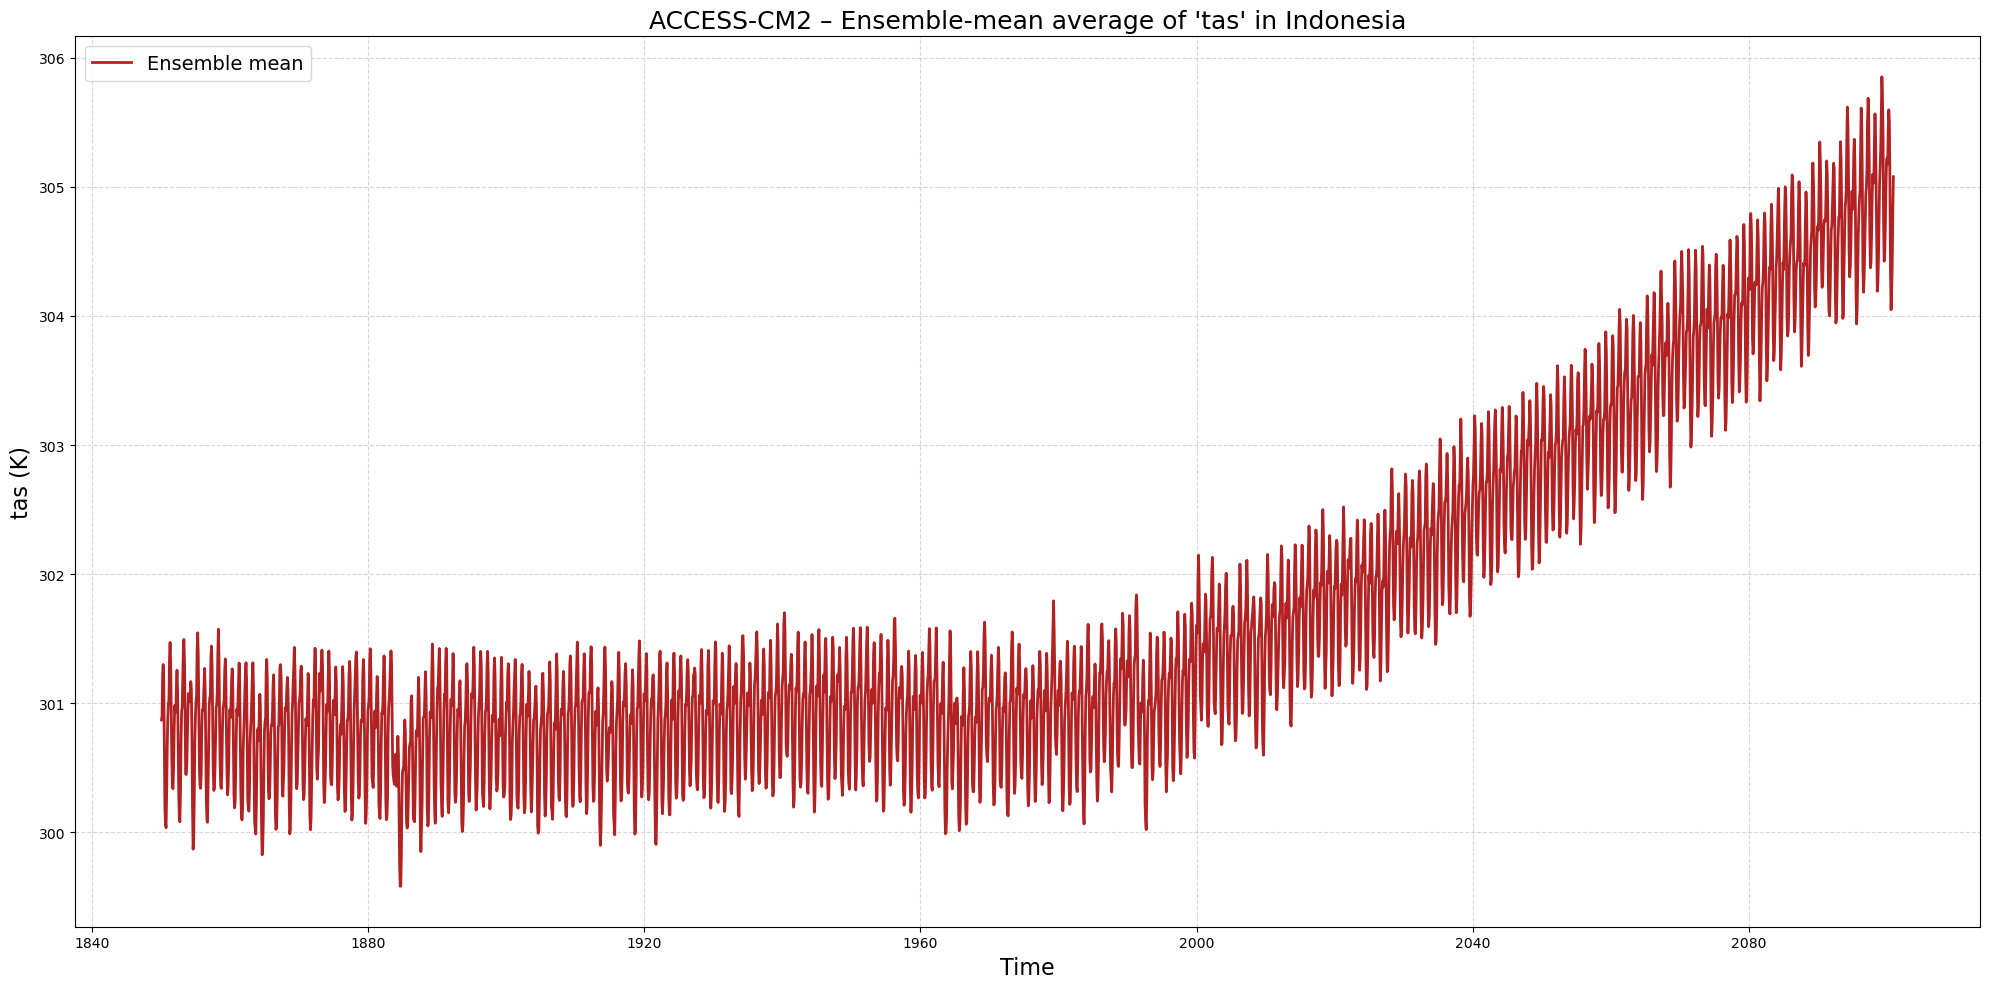

In [14]:
model_climate_timeseries('ACCESS-CM2', 'tas')